# Dataset Corruption Analysis

In this notebook, I'll show how to find errors in the dataset in a semi-automatic way.

In [ ]:
%load_ext autoreload
%autoreload 2

This tutorial lets you identify mislabelings in the data using the trained models. First, make sure to locate all the data in the `initial_data` folder (in a format of `initial_data/<Class Name>/<Img>.jpg`.

In [3]:
import os
assert os.path.exists('initial_data')

First, let's restructure the data.

In [11]:
import pickle
from cv.identification.utils import reorganize_folder2

tagged, inverse_mapping = reorganize_folder2('initial_data/',  'data/', verbose=True)

**NOTE: I'm writing this tutorial on a MacBook without Nvidia GPU, so I'll be using a reduced dataset with around 40 classes. Your numbers and results may vary.**

In [14]:
items = sorted(os.listdir('data'))
len(items)

512

Let's do some sanity check...

In [15]:
for item in items:
    assert item in tagged, item

As always, `DataManager` and `ImgReader` will be our good friends.

In [16]:
from cv.identification.data_manager import DataManager
train_manager = DataManager(items, tagged)

In [23]:
from cv.identification.io import ImgReader

IMG_SHAPE = (256, 256, 3)
reader = ImgReader(IMG_SHAPE, paths=['data/'])

In [20]:
from cv.identification.siamese.nets import create_branch, create_head, create_siamese
from cv.identification.siamese.utils import parse_model

Make sure to locate the trained Keras model. Here, we'll be using Version 4 (RGB version).

In [21]:
from keras.models import load_model
model = load_model('model_4.flip_lr.hdf5')
branch_model, head_model = parse_model(model)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [24]:
from cv.identification.siamese.generators import FeatureGen
features = branch_model.predict_generator(FeatureGen(train_manager, reader, verbose=True), max_queue_size=32, workers=8, verbose=0)

In [26]:
from cv.identification.siamese.generators import ScoreGen
from cv.identification.siamese.utils import score_reshape
score = head_model.predict_generator(ScoreGen(features, verbose=True), max_queue_size=32, workers=12, verbose=0)
score_reshaped = score_reshape(score, features)

Sanity check - calculating accuracy on train set. It should be above 97% if you're using a good model.

In [27]:
metric = 0
import numpy as np
import tqdm
for i in tqdm.trange(len(score_reshaped)):
    index = np.argpartition(-score_reshaped[i], kth=2)
    result = index[0] if index[1] == i else index[1]
    if train_manager.tagged[train_manager.items[i]] == train_manager.tagged[train_manager.items[result]]:
        metric += 1
metric /= len(score_reshaped)
metric

100%|██████████| 512/512 [00:00<00:00, 75695.58it/s]


0.9765625

### DISCLAIMER: Dataset error finding is a *semi-automatic* process, meaning that you'll still have to go through the examples and manually verify the errors. It can't be fully automatic, otherwise it could've been possible to fix dataset mistakes for free. Instead, an already trained model will help you with selecting the most "problematic" classes. Amongst these, there will be classes that are correctly labeled, but the network is just having troubles with these classes. However, if the model is good, you'll also notice that it can greatly assist in finding classes that were labeled incorrectly.

Some utility function:

In [37]:
def show_two(first, second):
    import matplotlib.pyplot as plt
    import dlib
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(dlib.load_rgb_image('data/' + first))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(dlib.load_rgb_image('data/' + second))
    plt.axis('off')
    plt.show()

# 1. Errors within the same class

In [28]:
info = []
import tqdm
for cls, indices in tqdm.tqdm_notebook(train_manager.class2indices.items()):
    for i_ in range(len(indices)):
        i = indices[i_]
        for j_ in range(i_+1, len(indices)):
            j = indices[j_]
            info.append((score_reshaped[i][j], cls, train_manager.items[i], train_manager.items[j]))

/Users/Vlad/.virtualenvs/yolo/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
info = sorted(info) # by probability

In [38]:
i = -1

Now, launch the next cell until there are no more errors. Each time, go to the folder with samples, and manually fix the mistake. After that, add the class name to the `to_skip` variable, so that it won't be shown ever again.

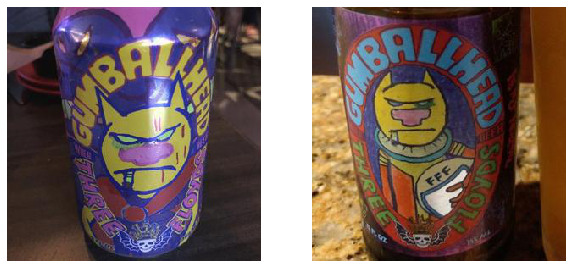

0 3 Floyds - Gumballhead_1
5.364418e-07


In [39]:
to_skip = ['3 Floyds - Gumballhead_1'] # <-- MODIFY THIS MANUALLY AFTER YOU FIX THE MISTAKE!
while True:
    i += 1
    item = info[i]
    if item[0] not in to_skip:
        show_two(item[2], item[3])
        print(i, item[1])
        print(item[0])
        break
    else:
        print(f'Skipping {i} ({info[i][1]})')

This is definitely an error!!

# 2. Errors within different classes

Now, let's select the **highest** probabilities amongst different classes.

In [40]:
info = []
import tqdm
for i in tqdm.trange(len(score_reshaped)):
    for j in range(i+1, len(score_reshaped)):
        if train_manager.tagged[train_manager.items[i]] != train_manager.tagged[train_manager.items[j]]:
            info.append((score_reshaped[i][j], (train_manager.tagged[train_manager.items[i]], train_manager.tagged[train_manager.items[j]]), train_manager.items[i], train_manager.items[j]))

100%|██████████| 512/512 [00:00<00:00, 2728.64it/s]


In [41]:
%%time

srt = np.argsort(-score_reshaped.ravel())

CPU times: user 15 ms, sys: 1.13 ms, total: 16.1 ms
Wall time: 15.3 ms


In [42]:
total = 0
idx = -1

Again, run the next cell multiple times until you no longer see any errors.

2657 (484/370)
0.9999914
('3 Floyds - Gumballhead_1', '3 Floyds - Gumballhead_2')


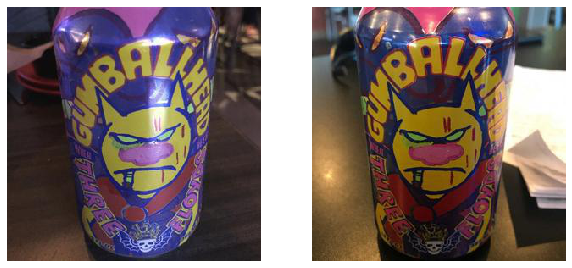

In [43]:
idx += 1
skip_classes = ['3 Floyds - Gumballhead_2'] # <-- Add classes here after you've processed them
while True:
    val = srt[idx]
    i = val // len(score_reshaped)
    j = val % len(score_reshaped)
    if train_manager.tagged[train_manager.items[i]] != train_manager.tagged[train_manager.items[j]]:
        print(f'{idx} ({i}/{j})')
        item = (score_reshaped[i][j], (train_manager.tagged[train_manager.items[i]], train_manager.tagged[train_manager.items[j]]), train_manager.items[i], train_manager.items[j])
        total += 1
        if item[1][0] in skip_classes or item[1][1] in skip_classes:
            print("Skipping", item[1][0])
            idx += 1
            continue
        break
    idx += 1
    
print(item[0])
print(item[1])
show_two(item[2], item[3])

We see an error again!!!

# 3. Most misclassified classes

The next type of errors happen when the accuracy for the class is the lowest:

In [44]:
from collections import defaultdict
cls2errors = defaultdict(list)
for i in range(len(score_reshaped)):
    index = np.argpartition(-score_reshaped[i], kth=2)
    result = index[0] if index[1] == i else index[1]
    if train_manager.tagged[train_manager.items[i]] != train_manager.tagged[train_manager.items[result]]:
        cls2errors[train_manager.tagged[train_manager.items[i]]].append(train_manager.tagged[train_manager.items[result]])

In [45]:
items = list(cls2errors.items())
items = sorted(items, key=lambda x:-len(x[1]))

In [46]:
i = -1

Run the next cell multiple times again!

In [47]:
i += 1
items[i]

('10 Barrel Brewing Co. - Pearl IPA',
 ['10 Barrel Brewing Co. - Joe',
  '10 Barrel Brewing Co. - Joe',
  '10 Barrel Brewing Co. - Joe',
  '10 Barrel Brewing Co. - Joe'])

Try to see if these classes are mislabelled.